In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.impute import SimpleImputer

## Загрузка и предобработка.

In [5]:
data = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Занятия с ментором\ML курс\ML-Course\data\podcasts.csv")

In [6]:
data.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 52500 non-null  object 
 1   Episode_Title                52500 non-null  object 
 2   Episode_Length_minutes       47254 non-null  float64
 3   Genre                        52500 non-null  object 
 4   Host_Popularity_percentage   52500 non-null  float64
 5   Publication_Day              52500 non-null  object 
 6   Publication_Time             52500 non-null  object 
 7   Guest_Popularity_percentage  47242 non-null  float64
 8   Number_of_Ads                52500 non-null  int64  
 9   Episode_Sentiment            52500 non-null  object 
 10  Listening_Time_minutes       47105 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 4.4+ MB


In [8]:
data.isna().sum()

Podcast_Name                      0
Episode_Title                     0
Episode_Length_minutes         5246
Genre                             0
Host_Popularity_percentage        0
Publication_Day                   0
Publication_Time                  0
Guest_Popularity_percentage    5258
Number_of_Ads                     0
Episode_Sentiment                 0
Listening_Time_minutes         5395
dtype: int64

In [9]:
data.dropna(subset=['Listening_Time_minutes'], inplace=True)

In [10]:
data.duplicated().sum()

2237

In [11]:
data.drop('Listening_Time_minutes', axis=1).duplicated().sum()

2237

In [12]:
data.drop_duplicates(inplace=True)

**Вывод по предобработке:**
- загрузили данные в которых порядка 50 тыс. объектов.
- всего 11 столбцов: 5 количественных, 6 -категориальных.
- Так как дубли не несут полезной информации для составления модели мы их удалили. Пропуски в тренировочных данных оставили, попробуем заменить их заглушками. Пропуски в целевом признаке удалены.

## Построим графики.

### Количественные признаки.

In [13]:
num_col = data.select_dtypes(include='number').columns.to_list()
cat_col = data.select_dtypes(exclude='number').columns.to_list()

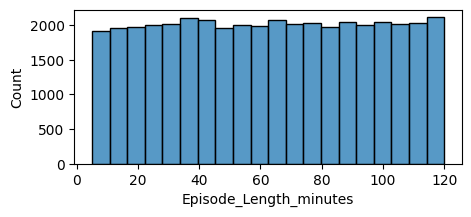

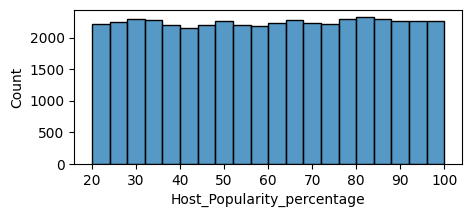

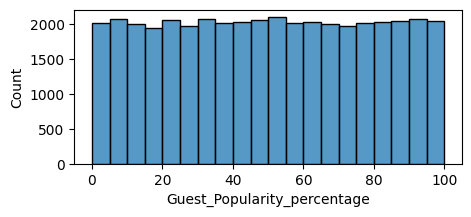

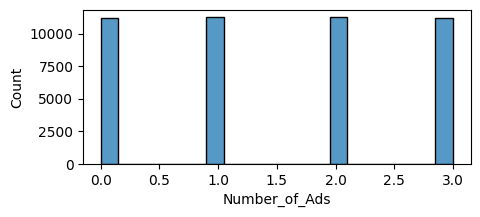

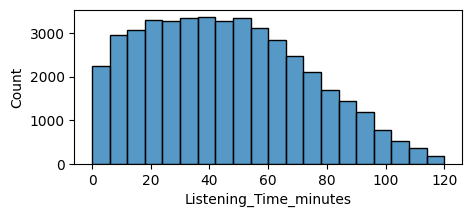

In [14]:
for i in range(len(num_col)):
    plt.figure(figsize=(5,2))
    sns.histplot(data=data, x=num_col[i], bins=20)

In [15]:
len(num_col)

5

Видно равномерное распределение всех чилосвых признаков кроме целевого. Целевой признак имеет тренд на снижение количества прослушиваний продолжительностью более 60 минут.

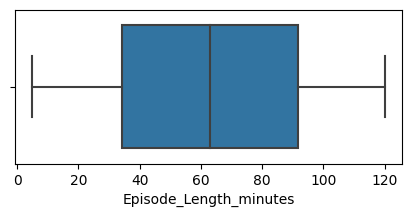

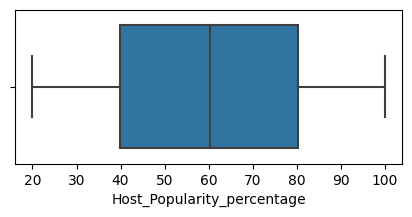

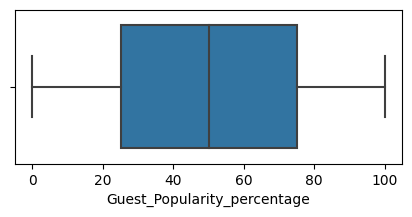

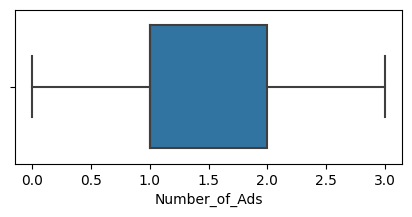

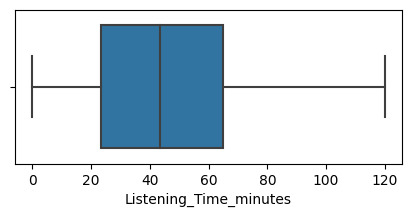

In [16]:
for i in range(len(num_col)):
    plt.figure(figsize=(5,2))
    sns.boxplot(data=data, x=num_col[i])

Все значения расположены в диапазоне усов графика - выбросов не выявлено.

посмотрим на зависимости целевой переменной от количественных признаков.

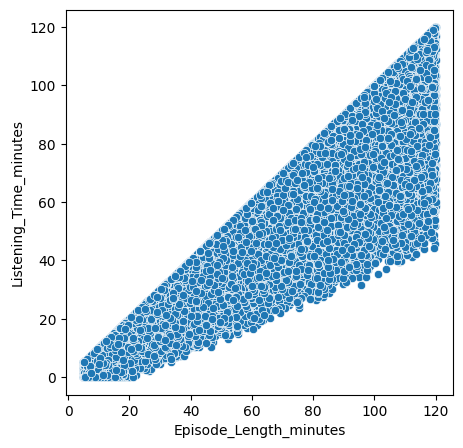

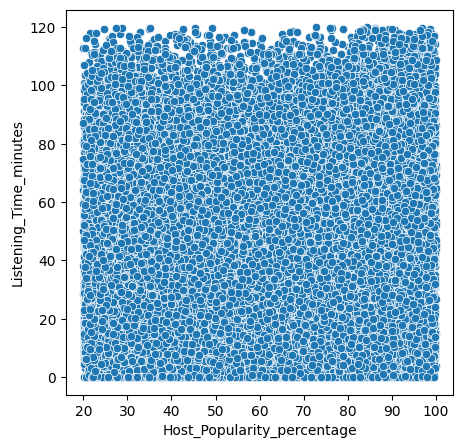

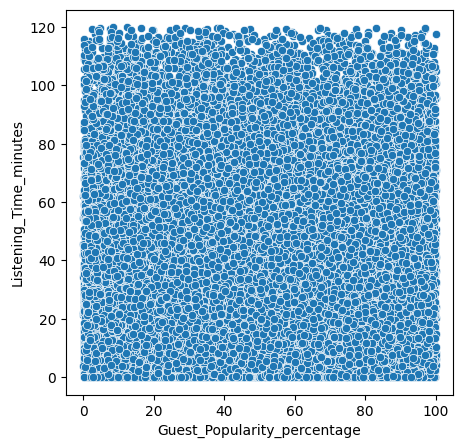

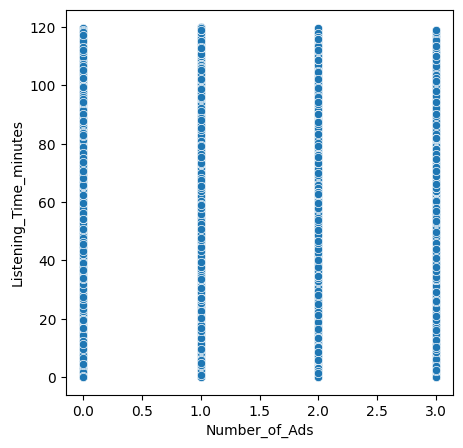

In [17]:
for i in range(len(num_col)-1):
    plt.figure(figsize=(5,5))
    sns.scatterplot(data=data, x=num_col[i], y=num_col[-1])

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Episode_Length_minutes,40374.0,62.911157,33.140476,5.00,34.372500,62.995000,91.660000,120.00
Host_Popularity_percentage,44868.0,60.164403,23.150859,20.00,39.980000,60.320000,80.310000,100.00
Guest_Popularity_percentage,40394.0,50.097692,28.857913,0.01,25.140000,50.125000,75.110000,100.00
Number_of_Ads,44868.0,1.500334,1.116351,0.00,1.000000,1.000000,2.000000,3.00
Listening_Time_minutes,44868.0,45.541663,27.141247,0.00,23.330685,43.555075,64.917734,119.97


- Два Количественные признаки выражены в процентах и один - длительность имеет примерно тот же масштаб что и целевой признак.
- `Number_of_Ads` относится скорее к категориальному признаку.
- Линейных зависимостей между количественными признаками и целевым согласно графиков нет. Зависимость между общей продолжительностью и продолжительностью прослушивания не имеет обобщающей способности. Конечно общая продолжительность подкаста оказывает влияние на время прослушивания, но этот фактор не "подталкивает" к увеличению интереса или вовлеченности в подкаст и зависимость здесь другого плана.

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'Episode_Length_minutes'),
  Text(1.5, 0, 'Host_Popularity_percentage'),
  Text(2.5, 0, 'Guest_Popularity_percentage'),
  Text(3.5, 0, 'Number_of_Ads'),
  Text(4.5, 0, 'Listening_Time_minutes')])

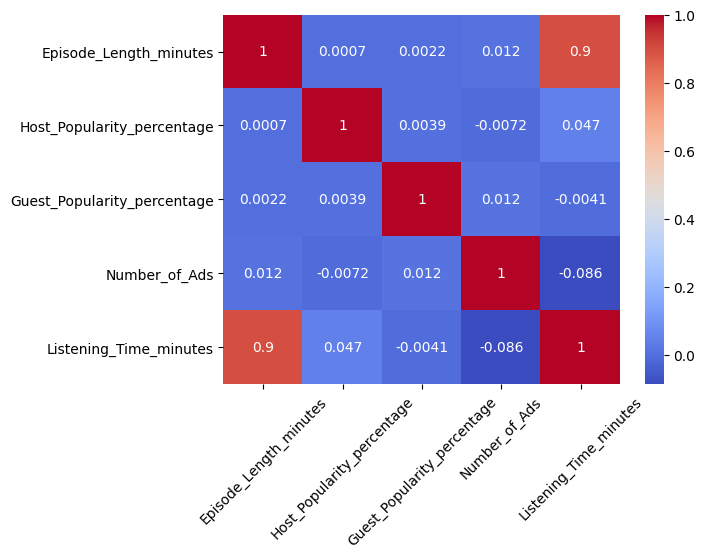

In [19]:
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.xticks(rotation=45)

### Категориальные признаки.

In [20]:
cat_col

['Podcast_Name',
 'Episode_Title',
 'Genre',
 'Publication_Day',
 'Publication_Time',
 'Episode_Sentiment']

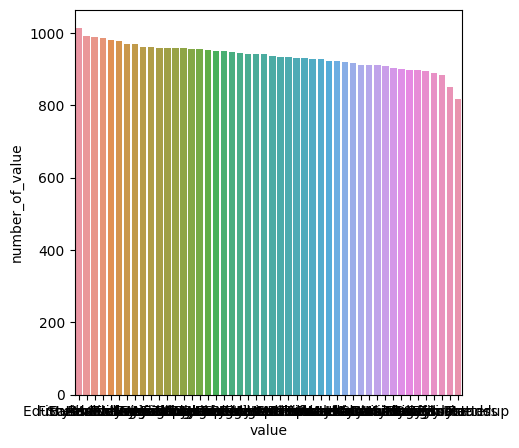

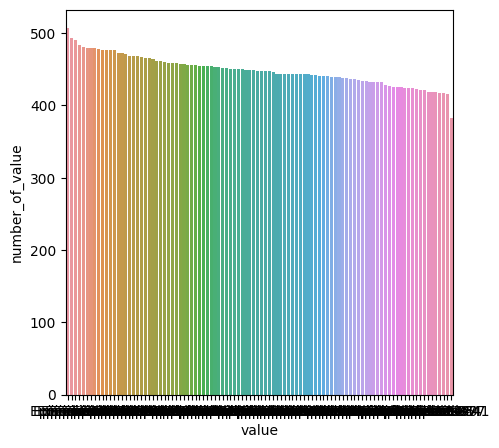

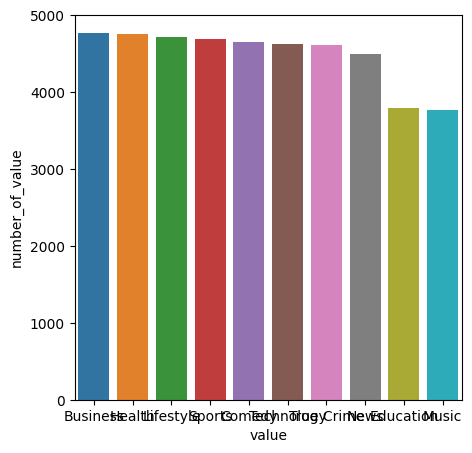

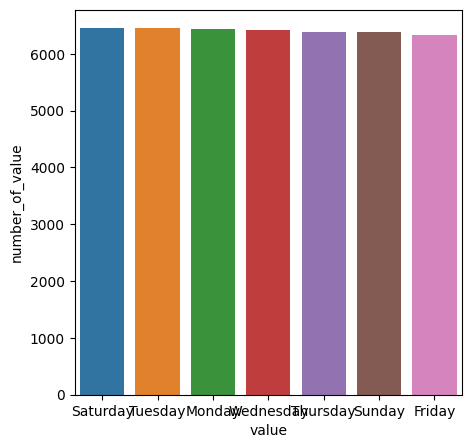

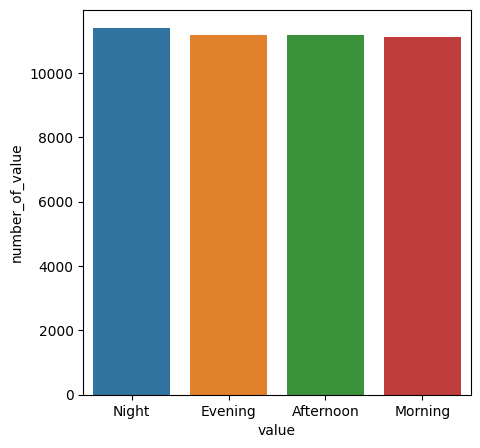

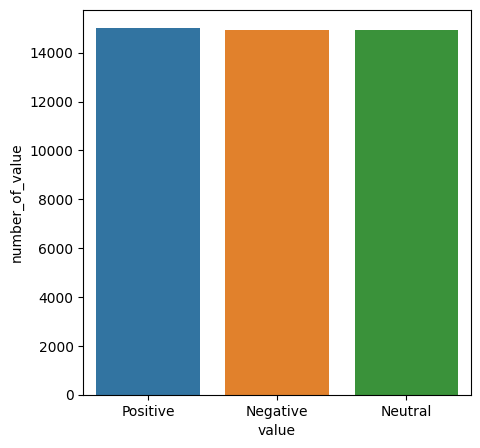

In [21]:
for i in range(len(cat_col)):
    data_value=data[cat_col[i]].value_counts().reset_index()
    data_value.columns=['value', 'number_of_value']

    plt.figure(figsize=(5,5))
    sns.barplot(data=data_value, y='number_of_value', x='value')

Категориальные признаки распределены равномерно.

## Подготовка данных модели.

### Закодируем категориальные признаки.

In [22]:
imputer=SimpleImputer(strategy='mean')

Вставим вместо пропусков средние значения.

In [23]:
data [num_col] = imputer.fit_transform(data[num_col])

In [24]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

In [25]:
features=data.drop('Listening_Time_minutes', axis=1)
target = data['Listening_Time_minutes']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=True)

In [32]:
encoder.fit(X_train[cat_col])

OneHotEncoder(drop='first', sparse_output=False)

In [33]:
encoder_cat = encoder.get_feature_names_out()

In [34]:
X_train[encoder_cat] = encoder.transform(X_train[cat_col])
X_test[encoder_cat] = encoder.transform(X_test[cat_col])

In [35]:
X_train.drop(cat_col, axis=1, inplace=True)
X_test.drop(cat_col, axis=1, inplace=True)

## Выбор метрики.

После анализа графиков выявлено, что выбросов нет, соответственно в качестве `loss` выберем MSE.

Оценивать качество модели будем по RMSE.

In [36]:
X_train.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Podcast_Name_Brain Boost,Podcast_Name_Business Briefs,Podcast_Name_Business Insights,Podcast_Name_Comedy Corner,Podcast_Name_Crime Chronicles,Podcast_Name_Criminal Minds,...,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_Neutral,Episode_Sentiment_Positive
count,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,...,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000,35894.000000
mean,62.878756,60.161693,50.054569,1.503037,0.020756,0.022149,0.021173,0.021006,0.020338,0.020700,...,0.143645,0.142252,0.142921,0.143004,0.143868,0.250070,0.246866,0.253914,0.333259,0.332980
std,31.425826,23.117946,27.371482,1.116200,0.142567,0.147169,0.143964,0.143407,0.141155,0.142379,...,0.350734,0.349313,0.349997,0.350082,0.350961,0.433059,0.431194,0.435255,0.471385,0.471286
min,5.000000,20.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.520000,40.020000,27.930000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62.911157,60.320000,50.097692,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,88.357500,80.277500,72.190000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,120.000000,99.990000,100.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Построим модель. Аналитический метод.

In [37]:
model = LinearRegression()

In [38]:
model.fit(X_train, y_train)

LinearRegression()

In [39]:
predict = model.predict(X_test)

In [40]:
RMSE = root_mean_squared_error (predict, y_test)

In [41]:
MAE = mean_absolute_error (predict, y_test)

In [42]:
RMSE

13.998336551532534

In [43]:
MAE

10.427386492251706

## Построим модель. Градиентный спуск.

In [45]:
# функция градиента MSE по w
def calculate_gradient_mse(
    X: np.ndarray, y: np.ndarray, y_pred: np.ndarray
) -> np.ndarray:
    return -2 * X.T @ (y - y_pred) / y.shape[0]

In [50]:
# данные в виде векторов/матриц
X = X_train.values  # матрица размерности (n_samples, n_features)
y = y_train.values  # вектор размерности (n_samples)

# добавим bias (столбец из единиц) к признакам
X = np.hstack([np.ones((X.shape[0], 1)), X]) # (n_samples, n_features + 1)

# инициализация
n_features = X.shape[1]
W = np.zeros(n_features)           # начальные веса (вектор)
weights_history = [W.copy()]       # история весов
mse_history = []                   # история ошибок
eta = 1e-6                         # скорость обучения
eps = 1e-5                         # порог останова
weights_diff = np.inf              # изначально большая разница
i = 0                              # итератор
show_loss = True

# логика алгоритма (градиентный спуск)
while weights_diff > eps:

    # прогнозируем
    y_pred = X @ W

    # вычисляем MSE
    mse = np.mean((y - y_pred) ** 2)

    # вычисляем градиент ошибки
    mse_grad = calculate_gradient_mse(X, y, y_pred)

    # вычисляем новые веса (формула градиентного спуска)
    w_new = W - eta * mse_grad

    # вычисляем раницу между весами (чтобы понимать когда останавливать алгоритм градиентного спуска)
    weights_diff = np.linalg.norm(w_new - W)  # разница между старыми и новыми весами (норма вектора)
    
    # сохраянем веса модели и ошибку
    weights_history.append(w_new.copy())
    mse_history.append(mse)

    W = w_new
    i += 1

    if show_loss and i % 100 == 0:
        print(f'MSE -> {mse:.6f}')

# результат
print('\nЧисло итераций (Градиентный Спуск): ', len(weights_history))
print('Оптимальные веса: ', weights_history[-1])


MSE -> 411.748504
MSE -> 328.251975
MSE -> 289.890191
MSE -> 262.856170
MSE -> 243.616656
MSE -> 229.916148
MSE -> 220.155321
MSE -> 213.197648
MSE -> 208.235224
MSE -> 204.693576
MSE -> 202.164083
MSE -> 200.355991
MSE -> 199.062334
MSE -> 198.135731
MSE -> 197.471179
MSE -> 196.993838
MSE -> 196.650331
MSE -> 196.402575
MSE -> 196.223377
MSE -> 196.093309
MSE -> 195.998480
MSE -> 195.928954
MSE -> 195.877613
MSE -> 195.839357
MSE -> 195.810528
MSE -> 195.788498
MSE -> 195.771379
MSE -> 195.757812

Число итераций (Градиентный Спуск):  2899
Оптимальные веса:  [ 1.73927927e-03  7.19144697e-01  2.86642783e-02 -2.34950769e-02
 -1.34027994e-02 -1.26368701e-05 -1.92240051e-05 -7.42131454e-05
 -1.25612103e-04  2.65615772e-04  1.90947323e-04  3.66030637e-05
 -6.27410365e-05  4.61455486e-05  2.13370866e-04  8.53575549e-07
 -1.80809121e-05 -5.24618479e-05 -4.83814224e-05  1.95424591e-05
  2.09938992e-04  1.03083605e-04 -4.46162292e-06 -7.40527953e-05
 -3.30718929e-05  2.15046000e-05  1.18490410